# HyperPipes

HyperPipes é um algoritmo de classificação desenvolvido por Lucio de Souza Coelho,  Universidade Federal de Minas Gerais, e posteriormente aperfeiçoado por Len Trigg, The University of Waikato, originalmente publicado na versão estável 3.2 do Weka em 1999. O algoritmo básico consiste em criar hipercubos definidos a partir das fronteiras de cada dimensão das classes presentes, em novas instâncias são classificadas de acordo com o hipercubo que mais engloba-la. Apesar de ser um algoritmo muito simples, possui como maior vantagem ser extremamente rápido, devido a sua baixa complexidade de tempo e memória computacional. Ele funciona bem quando há uma quantidade muito grande de atributos e/ou as classes são bem separadas e definidas no espaço amostral.

## Implementação

O algoritmo é implementado abaixo. Separou-se o conceito de um único *HiperPipe* (representando uma classe), do conceito de *n* multiplos *HiperPipes*, para facilitar a compreensão da implementação.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import os

from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits, make_classification
from sklearn.cross_validation import StratifiedKFold, cross_val_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

from itertools import product

C:\Users\altargin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class HyperPipe:
    
    def __init__(self):
        self.n_dimensions = 0
        self.numerical_bounds = []

    def fit(self, data_x, target_class):
        self.target_class = target_class
        self.n_dimensions = data_x.shape[1]

        # Initializes bounds
        for i in range(self.n_dimensions):
            bounds = []
            bounds.append(float('+inf'))  # lower bound
            bounds.append(float('-inf'))  # upper bound
            self.numerical_bounds.append(bounds)

        # Add instances
        for i in range(data_x.shape[0]):
            self.__add_instance__(data_x[i])

        return None

    def __add_instance__(self, data_x):
        #check boundaries
        for i in range(self.n_dimensions):
            if(data_x[i] < self.numerical_bounds[i][0]):
                self.numerical_bounds[i][0] = data_x[i]
            if(data_x[i] > self.numerical_bounds[i][1]):
                self.numerical_bounds[i][1] = data_x[i]

        return None

    def partial_contains(self, data_x):
        count = 0
        for i in range(self.n_dimensions):
            if(data_x[i] > self.numerical_bounds[i][0] and data_x[i] < self.numerical_bounds[i][1]):
                count += 1
        score = float(count) / self.n_dimensions

        return (score, self.target_class)

In [3]:
from sklearn.base import BaseEstimator

class HyperPipes(BaseEstimator):

    def __init__(self):
        self.hyper_pipes = []

    def fit(self, data_x, data_y):
        self.y_unique_values, self.y_unique_indices = np.unique(
            data_y, return_inverse=True)
        self.n_y_unique = self.y_unique_values.shape[0]
        self.hyper_pipes = [HyperPipe() for i in range(self.n_y_unique)]

        for i in range(self.n_y_unique):
            target_class = self.y_unique_values[i]
            target_class_indices = np.where(data_y == target_class)
            data_x_filtered = data_x[target_class_indices]
            self.hyper_pipes[i].fit(data_x_filtered, target_class)

        return self

    def predict(self, data_x):
        predictions = []
        for instance in data_x:
            partial_results = []
            for i in range(self.n_y_unique):
                partial_results.append(self.hyper_pipes[i].partial_contains(instance))
            best = max(partial_results,key=lambda item:item[0])[1]
            predictions.append(best)

        return predictions

### Simples exemplo do funcionamento

In [4]:
def getVisualHyperPipe(numerical_bounds, color):
    min_x, max_x = numerical_bounds[0][0], numerical_bounds[0][1]
    min_y, max_y = numerical_bounds[1][0], numerical_bounds[1][1]
    return Rectangle((min_x, min_y), (max_x - min_x), (max_y - min_y), fill=None, alpha=1, edgecolor=color)

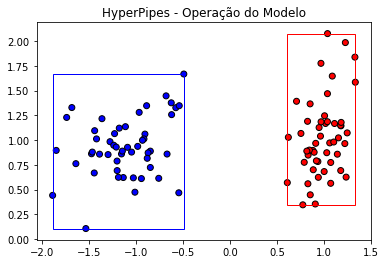

In [5]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)

hp = HyperPipes()
hp.fit(X,y)

colorMap = ListedColormap(['#FF0000', '#0000FF'])
colors = ['r', 'b']

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colorMap, edgecolors='k')

# Plot the Hyper Pipes
currentAxis = plt.gca()
for pipe, color in zip(hp.hyper_pipes, colors):
    rect = getVisualHyperPipe(pipe.numerical_bounds, color)
    currentAxis.add_patch(rect)

plt.title('HyperPipes - Operação do Modelo')
plt.show()

### Benchmark

O HyperPipes consegue ser performático em bases de dados com excessivos atributos e/ou classes bem separadas no espaço amostral, porém geralmente não desempenha bem caso contrário. Quando o algoritmo foi incorporado no pacote de Machine Learning Weka, muitos estudos de benchmark de classificadores para diversos problemas foram realizados.

Delgado e Amorim realizaram um estudo de avaliação envolvendo 179 classificadores oriundos de 17 famílias (discriminant analysis, Bayesian, neural networks, support vector machines, decision trees, rule-based classiﬁers, boosting, bagging, stacking, random forests e outros ensembles, generalized linear models, nearest-neighbors, partial least squares e principal component regression, logistic e multinomial regression, multiple adaptive regression splines e outros métodos), implementados em Weka, R, C e Matlab. Eles usaram 121 bases de dados distintas, representando a maior parte dos presentes na UCI e de outras fontes. Segundo os rankings de Friedman, acurácia média e Cohen k, o HyperPipes ocupou a posição 167 dos 179 classificadores das diversas famílias. Em sua família específica, a de outros métodos, ocupou a posição 8 dentre os 10 presentes.

Em outro estudo de para um problema específico de uso de aprendizado de máquina aplicado a trajetórias dinâmicas de moléculas, HyperPipes obteve o 44 lugar dos 65 classificadores de diversas famílias do Weka, ao passo que foi o primeiro dentre os 3 de categoria outro (ou miscelânea).

Abaixo é feito uma simples demonstração de performance do HiperPipes frente a outros algoritmos.

In [6]:
class custom_datasets():
    
    @classmethod
    def load_ionosphere(self):
        return self.load_custom_dataset('..\\datasets\\ionosphere.data')

    @classmethod
    def load_wine(self):
        return self.load_custom_dataset('..\\datasets\\wine_processed.data')

    @classmethod
    def load_live_disorders(self):
        return self.load_custom_dataset('..\\datasets\\bupa.data')
    
    @classmethod
    def load_vehicle(self):
        dataset = self.load_custom_dataset('..\\datasets\\vehicle.data', 'int')
        dataset.data = dataset.data[1:]
        dataset.target = dataset.target[1:]
        return dataset

    @classmethod
    def load_balance_scale(self):
        return self.load_custom_dataset('..\\datasets\\balance-scale.data')
    
    @classmethod
    def load_zoo(self):
        #dataset = self.load_custom_dataset('..\\datasets\\skin-segmentation.data')
        #dataset.data = dataset.data[1:]
        #dataset.target = dataset.target[1:]
        #return dataset
        return self.load_custom_dataset('..\\datasets\\zoo.data')
    
    @classmethod
    def load_custom_dataset(self, path, dtype='float64'):
        dir = os.getcwd()
        file_name = os.path.join(dir, path)

        data = np.genfromtxt(file_name, delimiter=',', dtype=dtype)
            
        n_cols = data.shape[1]

        X = data[:,0:n_cols-1]
        y =np.genfromtxt(file_name, delimiter=',', usecols=(n_cols-1), dtype=None)

        return Dataset(X, y)
    

class Dataset:

    def __init__(self, X, y):
        self.data = X
        self.target = y

In [7]:
def print_score(score):
    mean = np.mean(score)
    std  = np.std(score)
    print('* ' + name + ':\t' + str(mean) + ' ± ' + str(std))

In [8]:
classifiers_names = ["HyperPipes", "Naive Bayes"]

classifiers = [
    HyperPipes(),
    GaussianNB()
]

In [9]:
datasets_names  = [
    "Iris",
    "Wine",
    "Ionosphere",
    "Live_Disorders",
    "Vehicle",
    "Balance_Scale",
    "Zoo"
]

datasets = [
    load_iris(),
    custom_datasets.load_wine(),
    custom_datasets.load_ionosphere(),
    custom_datasets.load_live_disorders(),
    custom_datasets.load_vehicle(),
    custom_datasets.load_balance_scale(),
    custom_datasets.load_zoo()
]

In [10]:
for dataset_name, dataset in zip(datasets_names, datasets):

    X, y = dataset.data, dataset.target

    X = StandardScaler().fit_transform(X)
    
    folds = StratifiedKFold(y, n_folds=10, random_state=8893)
    
    print(dataset_name)
    for name, clf in zip(classifiers_names, classifiers):
        score = cross_val_score(clf, X, y, scoring='accuracy', cv=folds)
        print_score(score)

Iris
* HyperPipes:	0.9466666666666667 ± 0.06531972647421808
* Naive Bayes:	0.9533333333333334 ± 0.04268749491621898
Wine
* HyperPipes:	0.8953216374269004 ± 0.07571688098076965
* Naive Bayes:	0.9616959064327485 ± 0.042442001415448946
Ionosphere
* HyperPipes:	0.35887488328664807 ± 0.005687127277413435
* Naive Bayes:	0.8752614379084968 ± 0.06438572839880545
Live_Disorders
* HyperPipes:	0.45218487394957985 ± 0.018246907969527736
* Naive Bayes:	0.5476470588235294 ± 0.07786706254520474
Vehicle
* HyperPipes:	0.3750976896714443 ± 0.03814360012420727
* Naive Bayes:	0.4567802844336827 ± 0.05078030590686139
Balance_Scale
* HyperPipes:	0.07835545147020556 ± 0.003972748422054083
* Naive Bayes:	0.84079885506115 ± 0.09351161630621342
Zoo
* HyperPipes:	0.14671717171717172 ± 0.15918888277112375
* Naive Bayes:	0.9311868686868687 ± 0.059958796390228185


# Decomposição de Classes

Pelo fato do HyperPipes ser um classificador extremamente simples e estar associado a separação quase que linear das classes, ele acaba performando muito mal em testes de benchmarks com bases de dados de características genéricas. 

Uma maneira de aumentar a performance do algoritmo seria aplicar algum tipo de pré-processamento a entrada dos dados a fim de melhorar os modelos produzidos pelo algoritmo. Estudos propõem a utilização de técnicas de decomposição de classes usando algoritmos de clustering com o objetivo de melhorar a acurácia de classificadores simples – uma vez que a separação de classes prévia torne a nova distribuição mais fácil de ser explorada pelo classificador.

## Implementação Uniforme

Abaixo é implementado um agente de decomposição de classes que recebe como argumento de seu construtor um algoritmo de clusterização qualquer, bem como um parametro *k* do número de clusters por classe. Como pode ser visto na implementação, este decompositor opera de maneira **uniforme** sobre todas as classes, usando o mesmo parâmetro *k* de clusters para todas classes.

In [11]:
class UniformClassDecomposition:
    
    def __init__(self, algorithm, k):
        algorithm.set_params(n_clusters=k)
        self.algorithm = algorithm
        self.k = k

    def decompose(self, data_x, data_y):
        self.y_unique_values, self.y_unique_indices = np.unique(data_y, return_inverse=True)
        self.n_y_unique = self.y_unique_values.shape[0]

        renamed_data_x = np.array([])
        renamed_data_y = np.array([])
        for i in range(self.n_y_unique):
            target_class = self.y_unique_values[i]
            target_class_indices = np.where(data_y == target_class)

            data_i_x = data_x[target_class_indices]
            data_i_y = data_y[target_class_indices]
            fitted = self.algorithm.fit(data_i_x)
            labels = fitted.labels_
            
            for j in range(self.k):
                indices_j = np.where(labels == j)
                data_j_x = data_i_x[indices_j]
                data_j_y = data_i_y[indices_j]

                relabed = self.relabel(data_j_y, j)

                renamed_data_x = np.append(renamed_data_x, data_j_x)
                renamed_data_y = np.append(renamed_data_y, relabed)

        X = np.reshape(renamed_data_x, (data_x.shape[0], data_x.shape[1]))
        y = renamed_data_y
        
        return X, y

    def relabel(self, data, cluster_idx):
        return np.array(list(map(lambda item: str(item) + chr(65 + cluster_idx), data)))

### Exemplo

Um exemplo da ação de decomposição é mostrado abaixo.

Originalmente, o dataset de *Wine* possuia 3 classes, com respectivos labels de **0**, **1** e **2**:

In [12]:
dataset = load_wine()
X, y = dataset.data, dataset.target

set(y)

{0, 1, 2}

Após a decomposição de classes uniform, com *k=2*, teremos 6 novas classes.

Cada nova classe será resultado de um cluster, cujo nome é obtido a partir da função *relabel*.
Na implementação acima, o nome original da classe é concatenado com uma caractere, iniciando a indexação em *A*.

In [13]:
k = 2

kmeans = KMeans(random_state=42)
cd = UniformClassDecomposition(kmeans, k)

X_cd, y_cd = cd.decompose(X,y)

set(y_cd)

{'0A', '0B', '1A', '1B', '2A', '2B'}

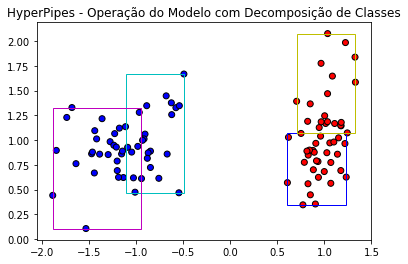

In [14]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)

cd = UniformClassDecomposition(KMeans(random_state=42), k=2)

X_cd, y_cd = cd.decompose(X,y)

hp = HyperPipes()
hp.fit(X_cd, y_cd)

colorMap = ListedColormap(['#FF0000', '#0000FF'])
colors = ['b', 'y', 'c', 'm']

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colorMap, edgecolors='k')

# Plot the Hyper Pipes
currentAxis = plt.gca()
for pipe, color in zip(hp.hyper_pipes, colors):
    rect = getVisualHyperPipe(pipe.numerical_bounds, color)
    currentAxis.add_patch(rect)

plt.title('HyperPipes - Operação do Modelo com Decomposição de Classes')
plt.show()

### Benchmark

In [15]:
k_values = [1, 2, 3, 4]

In [16]:
# clusterers_names = ["K-Means", "Spectral Clustering", "Agglomerative Clustering"]
clusterers_names = ["K-Means", "Agglomerative Clustering"]
#clusterers_names = ["K-Means"]

clusterers = [
    KMeans(random_state=8893),
    # SpectralClustering(random_state=8893),
    AgglomerativeClustering(n_clusters=k)
]

In [17]:
for k in k_values:
    print(k)

    for cst_name, cst in zip(clusterers_names, clusterers):
        print(cst_name)

        cd = UniformClassDecomposition(cst, k)

        for ds_name, ds in zip(datasets_names, datasets):
            print(ds_name)

            X, y = ds.data, ds.target
            
            y = LabelEncoder().fit_transform(y)

            X_cd, y_cd = cd.decompose(X,y)

            X_cd = StandardScaler().fit_transform(X_cd)

            folds = StratifiedKFold(y_cd, n_folds=10, random_state=8893)

            for name, clf in zip(classifiers_names, classifiers):
                score = cross_val_score(clf, X_cd, y_cd, scoring='accuracy', cv=folds)
                print_score(score)
        print()

1
K-Means
Iris
* HyperPipes:	0.9466666666666667 ± 0.06531972647421808
* Naive Bayes:	0.9533333333333334 ± 0.04268749491621898
Wine
* HyperPipes:	0.8953216374269004 ± 0.07571688098076965
* Naive Bayes:	0.9616959064327485 ± 0.042442001415448946
Ionosphere
* HyperPipes:	0.35887488328664807 ± 0.005687127277413435
* Naive Bayes:	0.8752614379084968 ± 0.06438572839880545
Live_Disorders
* HyperPipes:	0.45218487394957985 ± 0.018246907969527736
* Naive Bayes:	0.5476470588235294 ± 0.07786706254520474
Vehicle
* HyperPipes:	0.3750976896714443 ± 0.03814360012420727
* Naive Bayes:	0.4567802844336827 ± 0.05078030590686139
Balance_Scale
* HyperPipes:	0.07835545147020556 ± 0.003972748422054083
* Naive Bayes:	0.84079885506115 ± 0.09351161630621342
Zoo
* HyperPipes:	0.14671717171717172 ± 0.15918888277112375
* Naive Bayes:	0.9311868686868687 ± 0.059958796390228185

Agglomerative Clustering
Iris
* HyperPipes:	0.9466666666666667 ± 0.06531972647421808
* Naive Bayes:	0.9533333333333334 ± 0.04268749491621898
Wi

## Implementação Multi-Cluster

Um dos principais problemas da implementação uniforme vista acima é que supõe-se uma distribuição igualitária da quantidade de clusters dentro de cada classe - sendo esta uma hipótese muito forte e restrita a ser imposta sobre o conjunto de entrada e seu respectivo espaço amostral.

In [18]:
class MultiClusterClassDecomposition:
    
    def __init__(self, algorithm, k_values):
        self.algorithm = algorithm
        self.k_values = k_values

    def decompose(self, data_x, data_y):
        self.y_unique_values, self.y_unique_indices = np.unique(data_y, return_inverse=True)
        self.n_y_unique = self.y_unique_values.shape[0]

        renamed_data_x = np.array([])
        renamed_data_y = np.array([])
        for i in range(self.n_y_unique):
            target_class = self.y_unique_values[i]
            target_class_indices = np.where(data_y == target_class)

            data_i_x = data_x[target_class_indices]
            data_i_y = data_y[target_class_indices]
            
            k = self.k_values[target_class]
            self.algorithm.set_params(n_clusters=k)
            fitted = self.algorithm.fit(data_i_x)
            
            labels = fitted.labels_
            
            for j in range(k):
                indices_j = np.where(labels == j)
                data_j_x = data_i_x[indices_j]
                data_j_y = data_i_y[indices_j]

                relabed = self.relabel(data_j_y, j)

                renamed_data_x = np.append(renamed_data_x, data_j_x)
                renamed_data_y = np.append(renamed_data_y, relabed)

        X = np.reshape(renamed_data_x, (data_x.shape[0], data_x.shape[1]))
        y = renamed_data_y
        
        return X, y

    def relabel(self, data, cluster_idx):
        return np.array(list(map(lambda item: str(item) + chr(65 + cluster_idx), data)))

In [19]:
dataset = load_wine()
X, y = dataset.data, dataset.target

set(y)

{0, 1, 2}

In [20]:
k_values = {0: 1, 1: 2, 2: 1}

kmeans = KMeans(random_state=42)
cd = MultiClusterClassDecomposition(kmeans, k_values)

X_cd, y_cd = cd.decompose(X,y)

set(y_cd)

{'0A', '1A', '1B', '2A'}

### Extrator do Número de Clusters

In [21]:
[np.sqrt(len(d.data)) for d in datasets]

[12.24744871391589,
 13.341664064126334,
 18.734993995195193,
 18.57417562100671,
 29.068883707497267,
 25.0,
 10.04987562112089]

In [22]:
class ClusterExtractor:
    
    def __init__(self, clusterer):
        self.clusterer = clusterer
        
    def find_best_k(self, X, k_max):
        max_silhouette_avg = -1
        best_n_clusters = 0
        k_min = 2
        k_max = max(k_max, 2)
        
        for n_clusters in range(k_min, k_max + 1):
            self.__init_clusterer(n_clusters, 11) # seed = 11
            cluster_labels = self.clusterer.fit_predict(X)
            silhouette_avg = silhouette_score(X, cluster_labels)

            if(silhouette_avg > max_silhouette_avg):
                max_silhouette_avg = silhouette_avg
                best_n_clusters = n_clusters

        return best_n_clusters
    
    def __init_clusterer(self, n_clusters, random_state):
        self.clusterer.set_params(n_clusters=n_clusters, random_state=random_state)

In [23]:
class ClusterExtractorForDataset:
    
    def __init__(self):
        self.clusterer = KMeans()
        
    def find_best_k_values(self, X, y):
        
        self.y_unique_values, self.y_unique_indices = np.unique(y, return_inverse=True)
        self.n_y_unique = self.y_unique_values.shape[0]
        
        best_k_values = {}
        
        for i in range(self.n_y_unique):
            target_class = self.y_unique_values[i]
            target_class_indices = np.where(y == target_class)

            x = X[target_class_indices]
            k_max_X = int(np.floor(np.sqrt(len(x))))
            best_k_values[target_class] = ClusterExtractor(self.clusterer).find_best_k(x, k_max_X)
                
        return best_k_values

In [24]:
ce = ClusterExtractorForDataset()

dataset = load_wine()
X, y = dataset.data, dataset.target

k_values = ce.find_best_k_values(X,y)

k_values

{0: 4, 1: 2, 2: 3}

In [25]:
kmeans = KMeans(random_state=11)
cd = MultiClusterClassDecomposition(kmeans, k_values)

X_cd, y_cd = cd.decompose(X,y)

set(y_cd)

{'0A', '0B', '0C', '0D', '1A', '1B', '2A', '2B', '2C'}

# Unindo Decomposição de Classes com Ensemble

## Metodologia Proposta

![metodologia](../imgs/general-flow.png)

In [26]:
k_values

{0: 4, 1: 2, 2: 3}

In [27]:
n = len(k_values)
lst = list(map(list, product([1, -1], repeat=n)))

lst

[[1, 1, 1],
 [1, 1, -1],
 [1, -1, 1],
 [1, -1, -1],
 [-1, 1, 1],
 [-1, 1, -1],
 [-1, -1, 1],
 [-1, -1, -1]]

In [28]:
for i, k in enumerate(list(k_values.values())):
    for item in lst:
        if(item[i] == -1):
            item[i] = k

lst

[[1, 1, 1],
 [1, 1, 3],
 [1, 2, 1],
 [1, 2, 3],
 [4, 1, 1],
 [4, 1, 3],
 [4, 2, 1],
 [4, 2, 3]]

In [29]:
def get_all_combinations(k_values, y):
    n = len(k_values)
    lst = list(map(list, product([1, -1], repeat=n)))
    for i, k in enumerate(list(k_values.values())):
        for item in lst:
            if(item[i] == -1):
                item[i] = k
    unique_y = list(set(y))
    k_values_comb = []
    for i in range(len(lst)):
        k_values_comb.append({unique_y[j]: lst[i][j] for j in range(len(unique_y))})
    return k_values_comb

In [30]:
combinations = get_all_combinations(k_values, y)
combinations

[{0: 1, 1: 1, 2: 1},
 {0: 1, 1: 1, 2: 3},
 {0: 1, 1: 2, 2: 1},
 {0: 1, 1: 2, 2: 3},
 {0: 4, 1: 1, 2: 1},
 {0: 4, 1: 1, 2: 3},
 {0: 4, 1: 2, 2: 1},
 {0: 4, 1: 2, 2: 3}]

In [ ]:
for i, combination in enumerate(combinations):
    cd = MultiClusterClassDecomposition(KMeans(random_state=11), combination)
    X_cd, y_cd = cd.decompose(X,y)
    print(combination)
    print(set(y_cd))

{0: 1, 1: 1, 2: 1}
{'0A', '1A', '2A'}
{0: 1, 1: 1, 2: 3}
{'2B', '2C', '0A', '1A', '2A'}
{0: 1, 1: 2, 2: 1}
{'0A', '1A', '1B', '2A'}
{0: 1, 1: 2, 2: 3}
{'2B', '2C', '0A', '1A', '2A', '1B'}
{0: 4, 1: 1, 2: 1}
{'0C', '0B', '0A', '1A', '0D', '2A'}
{0: 4, 1: 1, 2: 3}
{'0C', '2B', '2C', '0B', '0A', '1A', '0D', '2A'}
{0: 4, 1: 2, 2: 1}
{'0C', '0B', '0A', '1A', '0D', '2A', '1B'}
{0: 4, 1: 2, 2: 3}
{'0C', '2B', '2C', '0B', '0A', '1A', '0D', '2A', '1B'}


In [ ]:
for cst_name, cst in zip(clusterers_names, clusterers):
    print(cst_name)

    for ds_name, ds in zip(datasets_names, datasets):
        print(ds_name)

        X, y = ds.data, ds.target

        y = LabelEncoder().fit_transform(y)

        ce = ClusterExtractorForDataset()
        k_values = ce.find_best_k_values(X,y)
        combinations = get_all_combinations(k_values, y)

        for i, combination in enumerate(combinations):
            print(combination)
            
            X_cd, y_cd = MultiClusterClassDecomposition(cst, combination).decompose(X,y)

            X_cd = StandardScaler().fit_transform(X_cd)

            folds = StratifiedKFold(y_cd, n_folds=10, random_state=8893)

            for name, clf in zip(classifiers_names, classifiers):
                score = cross_val_score(clf, X_cd, y_cd, scoring='accuracy', cv=folds)
                print_score(score)
    print()

K-Means
Iris
{0: 1, 1: 1, 2: 1}
* HyperPipes:	0.9466666666666667 ± 0.06531972647421808
* Naive Bayes:	0.9533333333333334 ± 0.04268749491621898
{0: 1, 1: 1, 2: 2}
* HyperPipes:	0.9215476190476191 ± 0.056712666403654875
* Naive Bayes:	0.9407142857142856 ± 0.045514662111457896
{0: 1, 1: 2, 2: 1}
* HyperPipes:	0.9285714285714285 ± 0.07253605718424964
* Naive Bayes:	0.9598214285714285 ± 0.05375711865532276
{0: 1, 1: 2, 2: 2}
* HyperPipes:	0.9039956367162251 ± 0.0793197104852682
* Naive Bayes:	0.9328579508726568 ± 0.05620268772009814
{0: 2, 1: 1, 2: 1}
* HyperPipes:	0.9211904761904762 ± 0.08154727146258908
* Naive Bayes:	0.9412499999999999 ± 0.05427713095258853
{0: 2, 1: 1, 2: 2}
* HyperPipes:	0.8963940960999786 ± 0.07389266221690582
* Naive Bayes:	0.9287677763413058 ± 0.05912564079189645
{0: 2, 1: 2, 2: 1}
* HyperPipes:	0.903417905623788 ± 0.09866153847348166
* Naive Bayes:	0.9471396250808016 ± 0.0639576721551795
{0: 2, 1: 2, 2: 2}
* HyperPipes:	0.8786939775910364 ± 0.10255373198181233
* Na

* Naive Bayes:	0.936923076923077 ± 0.05695410912035779
{0: 1, 1: 1, 2: 1, 3: 3, 4: 2, 5: 1, 6: 2}
* HyperPipes:	0.48356684981684983 ± 0.1419996401369071
* Naive Bayes:	0.9332005494505495 ± 0.06828639341391529
{0: 1, 1: 1, 2: 1, 3: 3, 4: 2, 5: 2, 6: 1}
* HyperPipes:	0.15164835164835164 ± 0.1740327696233945
* Naive Bayes:	0.9360576923076923 ± 0.0593832916276801
{0: 1, 1: 1, 2: 1, 3: 3, 4: 2, 5: 2, 6: 2}
* HyperPipes:	0.5071895424836602 ± 0.17420116795101642
* Naive Bayes:	0.932530345471522 ± 0.06899899045741856
{0: 1, 1: 1, 2: 2, 3: 1, 4: 1, 5: 1, 6: 1}
* HyperPipes:	0.1488034188034188 ± 0.16181417252509211
* Naive Bayes:	0.9406135531135531 ± 0.08154247710608195
{0: 1, 1: 1, 2: 2, 3: 1, 4: 1, 5: 1, 6: 2}
* HyperPipes:	0.4581585081585081 ± 0.08886192017757842
* Naive Bayes:	0.9239804639804641 ± 0.09203797057210672
{0: 1, 1: 1, 2: 2, 3: 1, 4: 1, 5: 2, 6: 1}
* HyperPipes:	0.1449925074925075 ± 0.15831404602427318
* Naive Bayes:	0.9440201465201465 ± 0.07636688476583225
{0: 1, 1: 1, 2: 2, 3: 1

* HyperPipes:	0.05706349206349206 ± 0.07545315356208843
* Naive Bayes:	0.9169108669108669 ± 0.07507839605604248
{0: 2, 1: 1, 2: 1, 3: 1, 4: 2, 5: 1, 6: 1}
* HyperPipes:	0.06742063492063492 ± 0.04637476532182748
* Naive Bayes:	0.9231349206349206 ± 0.05572989934069558
{0: 2, 1: 1, 2: 1, 3: 1, 4: 2, 5: 1, 6: 2}
* HyperPipes:	0.05427350427350427 ± 0.0679745153415554
* Naive Bayes:	0.9166874791874792 ± 0.06964474632837489
{0: 2, 1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 1}
* HyperPipes:	0.06725330225330226 ± 0.047863179118811564
* Naive Bayes:	0.9236655011655012 ± 0.0555879024139145
{0: 2, 1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2}
* HyperPipes:	0.0566468253968254 ± 0.07541046503610391
* Naive Bayes:	0.9171626984126984 ± 0.06812703047103412
{0: 2, 1: 1, 2: 1, 3: 3, 4: 1, 5: 1, 6: 1}
* HyperPipes:	0.0670054945054945 ± 0.048978893854715565
* Naive Bayes:	0.9288461538461539 ± 0.07966275068156914
{0: 2, 1: 1, 2: 1, 3: 3, 4: 1, 5: 1, 6: 2}
* HyperPipes:	0.055952380952380955 ± 0.0747273957358972
* Naive Bayes:	0

* HyperPipes:	0.07133870214752566 ± 0.06226931901823376
* Naive Bayes:	0.9348914565826331 ± 0.10603696774266173
{0: 2, 1: 4, 2: 2, 3: 3, 4: 1, 5: 1, 6: 2}
* HyperPipes:	0.1628361344537815 ± 0.07654850596857243
* Naive Bayes:	0.9218872549019608 ± 0.10577339246789431
{0: 2, 1: 4, 2: 2, 3: 3, 4: 1, 5: 2, 6: 1}
* HyperPipes:	0.07352124183006534 ± 0.06651794463557625
* Naive Bayes:	0.9388807189542483 ± 0.09948533437353761
{0: 2, 1: 4, 2: 2, 3: 3, 4: 1, 5: 2, 6: 2}
* HyperPipes:	0.17522230822153423 ± 0.08948205445280827
* Naive Bayes:	0.9243528551771586 ± 0.10048101027796995
{0: 2, 1: 4, 2: 2, 3: 3, 4: 2, 5: 1, 6: 1}
* HyperPipes:	0.0715613553113553 ± 0.06236813328817519
* Naive Bayes:	0.9420299145299145 ± 0.08449475829463049
{0: 2, 1: 4, 2: 2, 3: 3, 4: 2, 5: 1, 6: 2}
* HyperPipes:	0.16301992726915326 ± 0.07638003492509957
* Naive Bayes:	0.9285726571330286 ± 0.0843512108154924
{0: 2, 1: 4, 2: 2, 3: 3, 4: 2, 5: 2, 6: 1}
* HyperPipes:	0.07370503464543712 ± 0.06657104324569599
* Naive Bayes:	0.

* HyperPipes:	0.14944444444444444 ± 0.1615406152345916
* Naive Bayes:	0.9231349206349206 ± 0.05572989934069558
{0: 1, 1: 1, 2: 1, 3: 1, 4: 2, 5: 1, 6: 2}
* HyperPipes:	0.45646131646131644 ± 0.08793996234814193
* Naive Bayes:	0.9166874791874792 ± 0.06964474632837489
{0: 1, 1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 1}
* HyperPipes:	0.15019230769230768 ± 0.16154407041544588
* Naive Bayes:	0.9235042735042734 ± 0.05489739996885015
{0: 1, 1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2}
* HyperPipes:	0.46591644466644466 ± 0.1045709135619045
* Naive Bayes:	0.9169667832167832 ± 0.06773286909403387
{0: 1, 1: 1, 2: 1, 3: 3, 4: 1, 5: 1, 6: 1}
* HyperPipes:	0.15206043956043955 ± 0.17463978012352743
* Naive Bayes:	0.9365384615384615 ± 0.06650621717611763
{0: 1, 1: 1, 2: 1, 3: 3, 4: 1, 5: 1, 6: 2}
* HyperPipes:	0.48345238095238097 ± 0.14253381068437276
* Naive Bayes:	0.9328571428571429 ± 0.0753359821339155
{0: 1, 1: 1, 2: 1, 3: 3, 4: 1, 5: 2, 6: 1}
* HyperPipes:	0.15329670329670328 ± 0.17469503504994788
* Naive Bayes:	0.

* Naive Bayes:	0.9108660130718954 ± 0.10482026143790849
{0: 1, 1: 4, 2: 2, 3: 3, 4: 1, 5: 2, 6: 1}
* HyperPipes:	0.18895927601809953 ± 0.24076099467094664
* Naive Bayes:	0.9261928104575163 ± 0.0999850487028754
{0: 1, 1: 4, 2: 2, 3: 3, 4: 1, 5: 2, 6: 2}
* HyperPipes:	0.6008594402673351 ± 0.3071704199730976
* Naive Bayes:	0.9130847953216374 ± 0.10157213062974602
{0: 1, 1: 4, 2: 2, 3: 3, 4: 2, 5: 1, 6: 1}
* HyperPipes:	0.18791666666666665 ± 0.24105129986512555
* Naive Bayes:	0.9191666666666667 ± 0.10567573567811633
{0: 1, 1: 4, 2: 2, 3: 3, 4: 2, 5: 1, 6: 2}
* HyperPipes:	0.5713578960599085 ± 0.2749890777519513
* Naive Bayes:	0.906187650498796 ± 0.10672349697083654
{0: 1, 1: 4, 2: 2, 3: 3, 4: 2, 5: 2, 6: 1}
* HyperPipes:	0.19088235294117645 ± 0.24116373711005104
* Naive Bayes:	0.921514447884417 ± 0.10267928803998289
{0: 1, 1: 4, 2: 2, 3: 3, 4: 2, 5: 2, 6: 2}
* HyperPipes:	0.6017414529914531 ± 0.3064668663583486
* Naive Bayes:	0.908611111111111 ± 0.10325303032649907
{0: 2, 1: 1, 2: 1, 3: 1,